In [149]:
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn import linear_model
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from pydse.arma import minic, ARMA
from pydse.utils import make_lag_arr
%matplotlib inline

In [22]:
df = pd.read_pickle("../Data/Subway_Data/daily_count.pkl")
df.head()

,entries_diff,exit_diff
date,,
2015-01-03,2682846.0,2175723.0
2015-01-04,2481666.0,2028416.0
2015-01-05,5104111.0,4207769.0
2015-01-06,5061648.0,4224954.0
2015-01-07,5116883.0,4251015.0


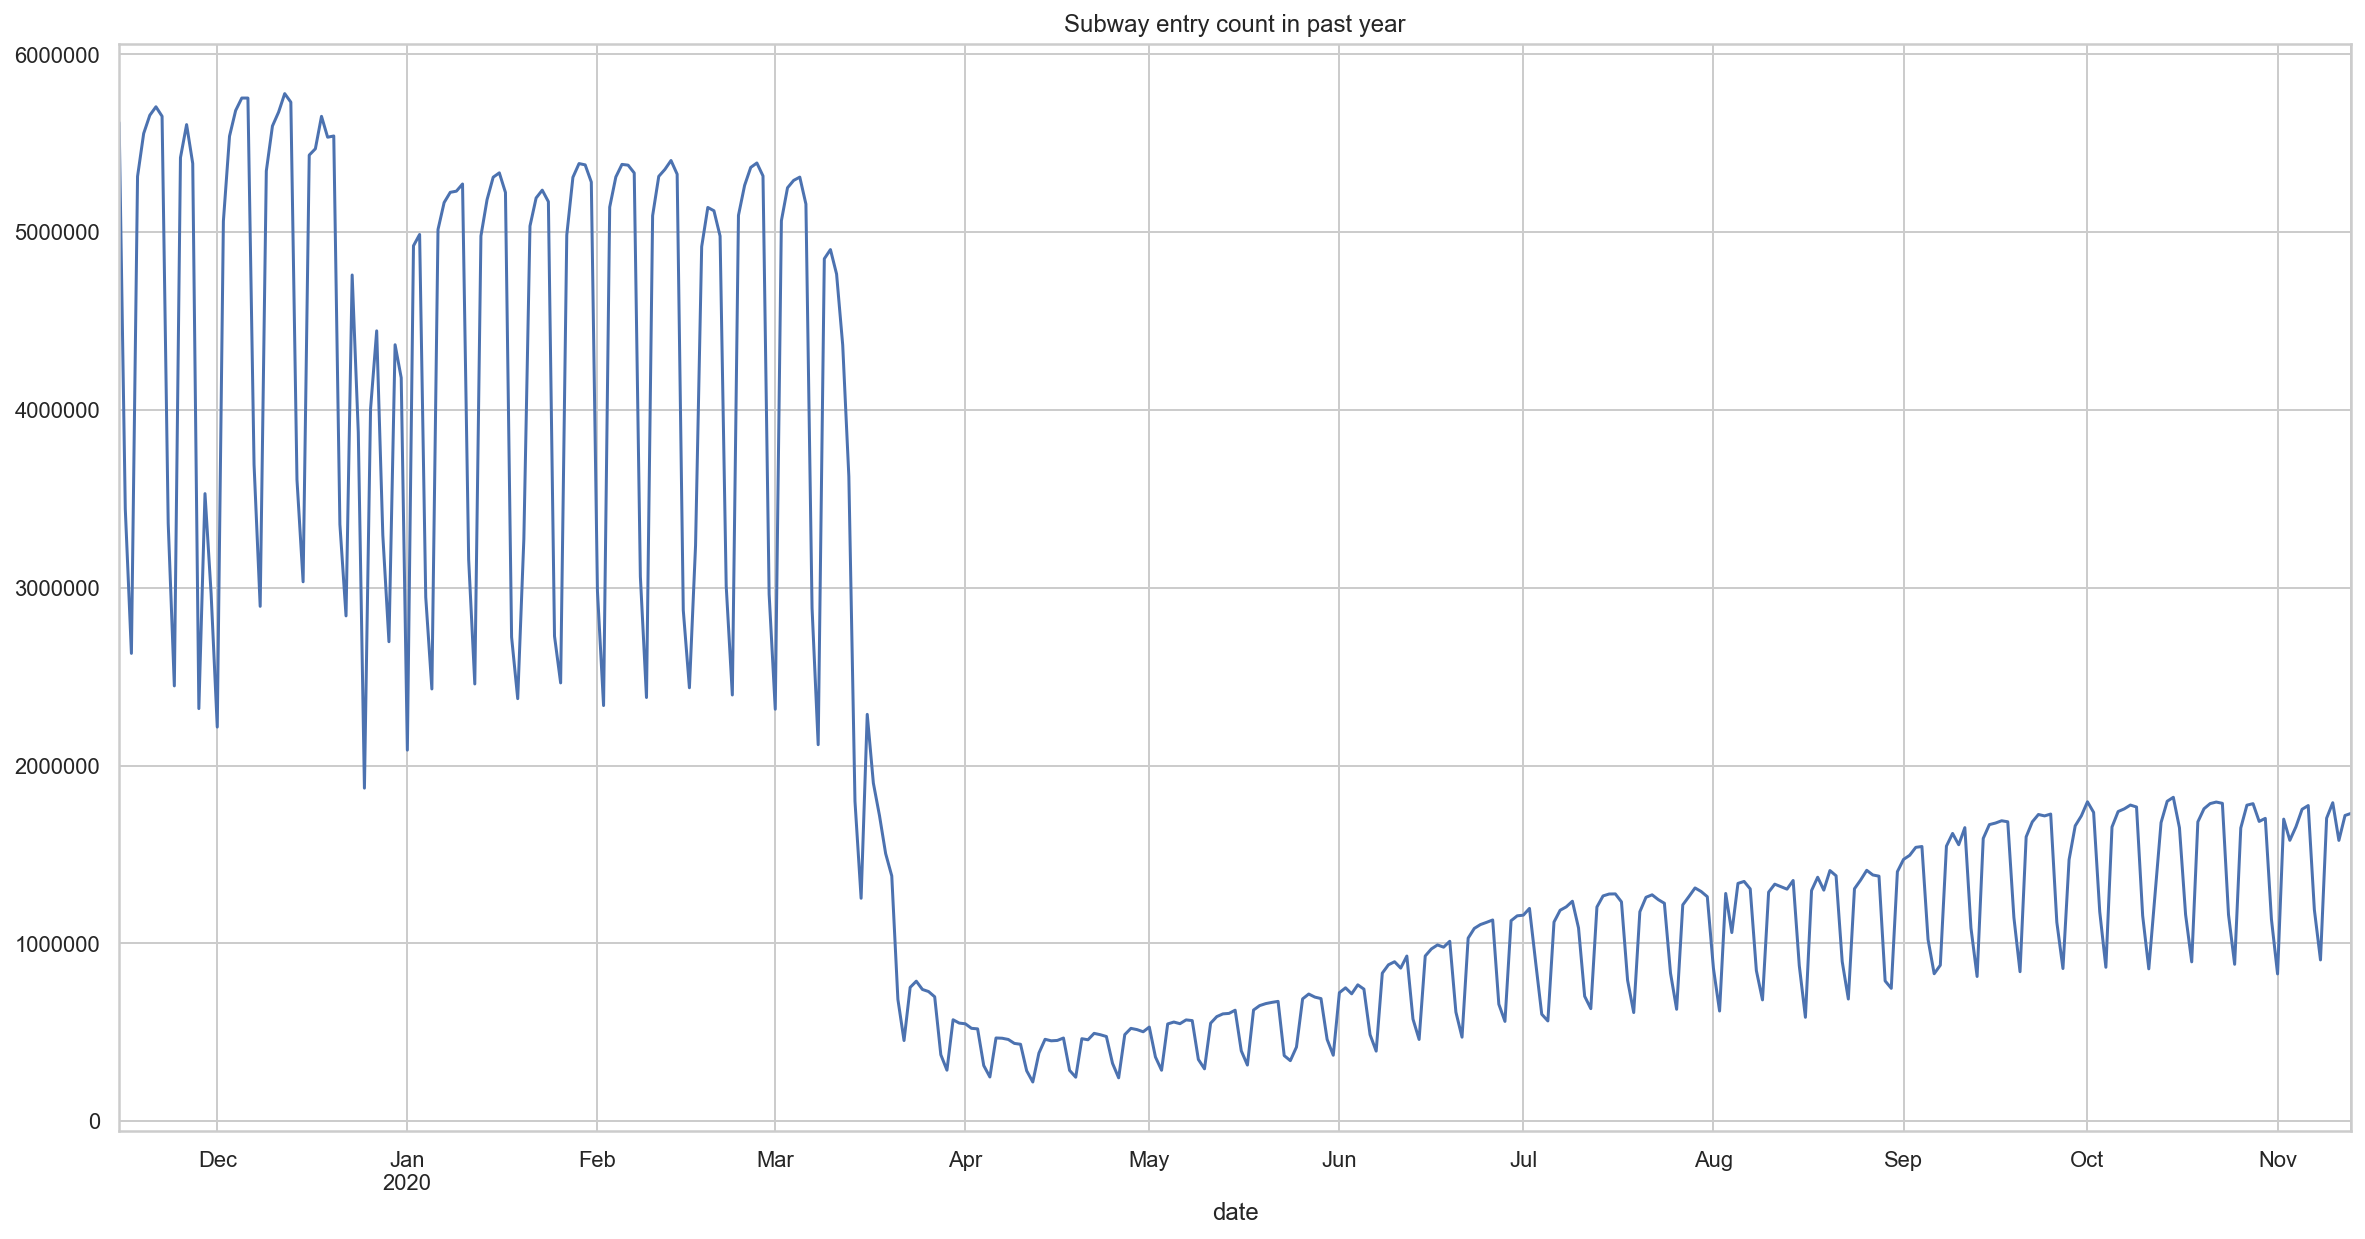

In [61]:
plt.figure(figsize=(20,10))
plt.title("Subway entry count in past year")
df["entries_diff"][-365:].plot()
plt.show()

## Find gaps in timeseries

In [24]:
df.reset_index(inplace=True)
df["timediff"] = (df['date'] - df['date'].shift(1)) / np.timedelta64(1, 'D')
df.set_index('date', inplace=True)

In [25]:
df['timediff'].value_counts()

# only have 1 day interval so good

1.0    2141
Name: timediff, dtype: int64

## Add columns for year, month, day, weekday

In [27]:
df['year'] = df.index.map(lambda x: x.year)
df['month'] = df.index.map(lambda x: x.month)
df['day'] = df.index.map(lambda x: x.day)
df['weekday'] = df.index.map(lambda x:x.weekday())
df.reset_index(inplace=True)
df.head()

,entries_diff,exit_diff,timediff,year,month,day,weekday
date,,,,,,,
2015-01-03,2682846.0,2175723.0,NaN,2015,1,3,5
2015-01-04,2481666.0,2028416.0,1.0,2015,1,4,6
2015-01-05,5104111.0,4207769.0,1.0,2015,1,5,0
2015-01-06,5061648.0,4224954.0,1.0,2015,1,6,1
2015-01-07,5116883.0,4251015.0,1.0,2015,1,7,2


In [80]:
df['timeindex'] = (df['date'] - pd.Timestamp('2015-01-03')) / np.timedelta64(1, 'D')

In [82]:
df.head()

,date,entries_diff,exit_diff,timediff,year,month,day,weekday,timeindex
0,2015-01-03,2682846.0,2175723.0,NaN,2015,1,3,5,0.0
1,2015-01-04,2481666.0,2028416.0,1.0,2015,1,4,6,1.0
2,2015-01-05,5104111.0,4207769.0,1.0,2015,1,5,0,2.0
3,2015-01-06,5061648.0,4224954.0,1.0,2015,1,6,1,3.0
4,2015-01-07,5116883.0,4251015.0,1.0,2015,1,7,2,4.0


## Data split - pre-Mar1st vs post-Mar1stt

In [83]:
df_preCovid = df[(df['date'] < '03-01-2020')]
df_preCovid.head()

,date,entries_diff,exit_diff,timediff,year,month,day,weekday,timeindex
0,2015-01-03,2682846.0,2175723.0,NaN,2015,1,3,5,0.0
1,2015-01-04,2481666.0,2028416.0,1.0,2015,1,4,6,1.0
2,2015-01-05,5104111.0,4207769.0,1.0,2015,1,5,0,2.0
3,2015-01-06,5061648.0,4224954.0,1.0,2015,1,6,1,3.0
4,2015-01-07,5116883.0,4251015.0,1.0,2015,1,7,2,4.0


In [84]:
df_postCovid = df[~(df['date'] < '03-01-2020')]
df_postCovid.head()

,date,entries_diff,exit_diff,timediff,year,month,day,weekday,timeindex
1884,2020-03-01,2316878.0,2080587.0,1.0,2020,3,1,6,1884.0
1885,2020-03-02,5064783.0,4371429.0,1.0,2020,3,2,0,1885.0
1886,2020-03-03,5250286.0,4579664.0,1.0,2020,3,3,1,1886.0
1887,2020-03-04,5291673.0,4594137.0,1.0,2020,3,4,2,1887.0
1888,2020-03-05,5310236.0,4901018.0,1.0,2020,3,5,3,1888.0


## Arima model
- not really good for non-stationary
- remove seasonality
- remove linear trend

### remove linear trend
- using only **df_preCovid_train**

In [87]:
X_train = np.c_[df_preCovid_train['timeindex']]
y_train = df_preCovid_train['entries_diff']

X_full = np.c_[df_preCovid['timeindex']]

In [93]:
len(X_train), len(y_train), len(X_full)

(1459, 1459, 1884)

In [96]:
linreg = linear_model.LinearRegression()
linreg.fit(X_train, y_train)
df_preCovid['trend'] = linreg.predict(X_full)

In [103]:
df_preCovid.set_index('date', inplace=True)
df_preCovid.head()

,entries_diff,exit_diff,timediff,year,month,day,weekday,timeindex,trend
date,,,,,,,,,
2015-01-03,2682846.0,2175723.0,NaN,2015,1,3,5,0.0,4.713360e+06
2015-01-04,2481666.0,2028416.0,1.0,2015,1,4,6,1.0,4.713276e+06
2015-01-05,5104111.0,4207769.0,1.0,2015,1,5,0,2.0,4.713192e+06
2015-01-06,5061648.0,4224954.0,1.0,2015,1,6,1,3.0,4.713108e+06
2015-01-07,5116883.0,4251015.0,1.0,2015,1,7,2,4.0,4.713024e+06


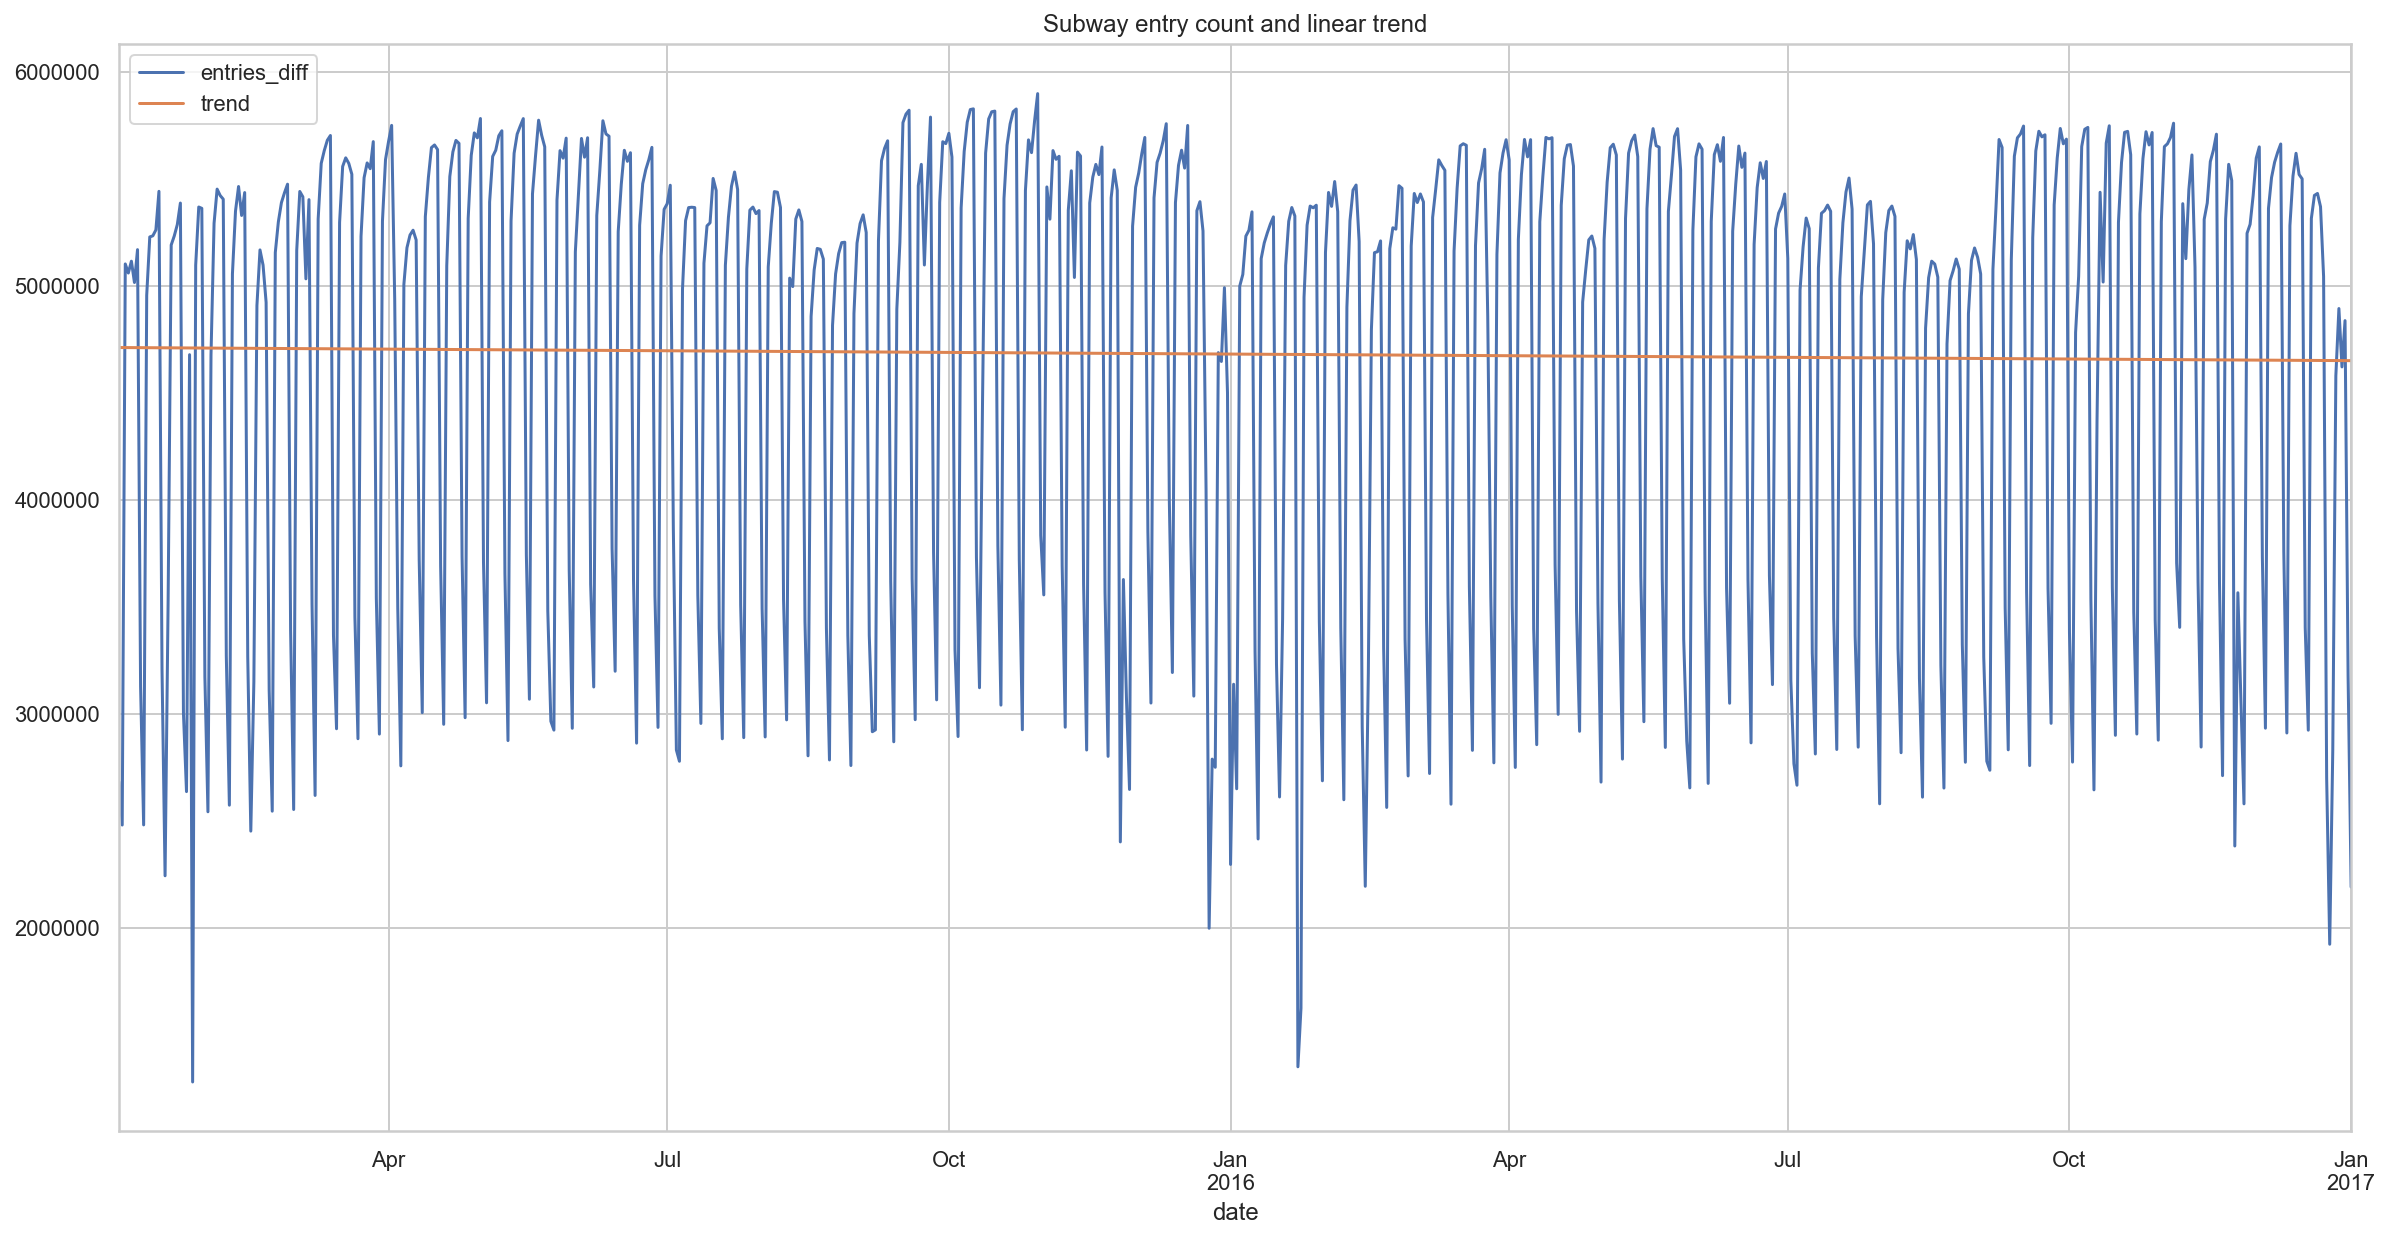

In [108]:
plt.figure(figsize=(20,10))
plt.title("Subway entry count and linear trend")
df_preCovid["entries_diff"][:730].plot()
df_preCovid["trend"][:730].plot()

plt.legend(loc=2)
plt.show()

### detrend it

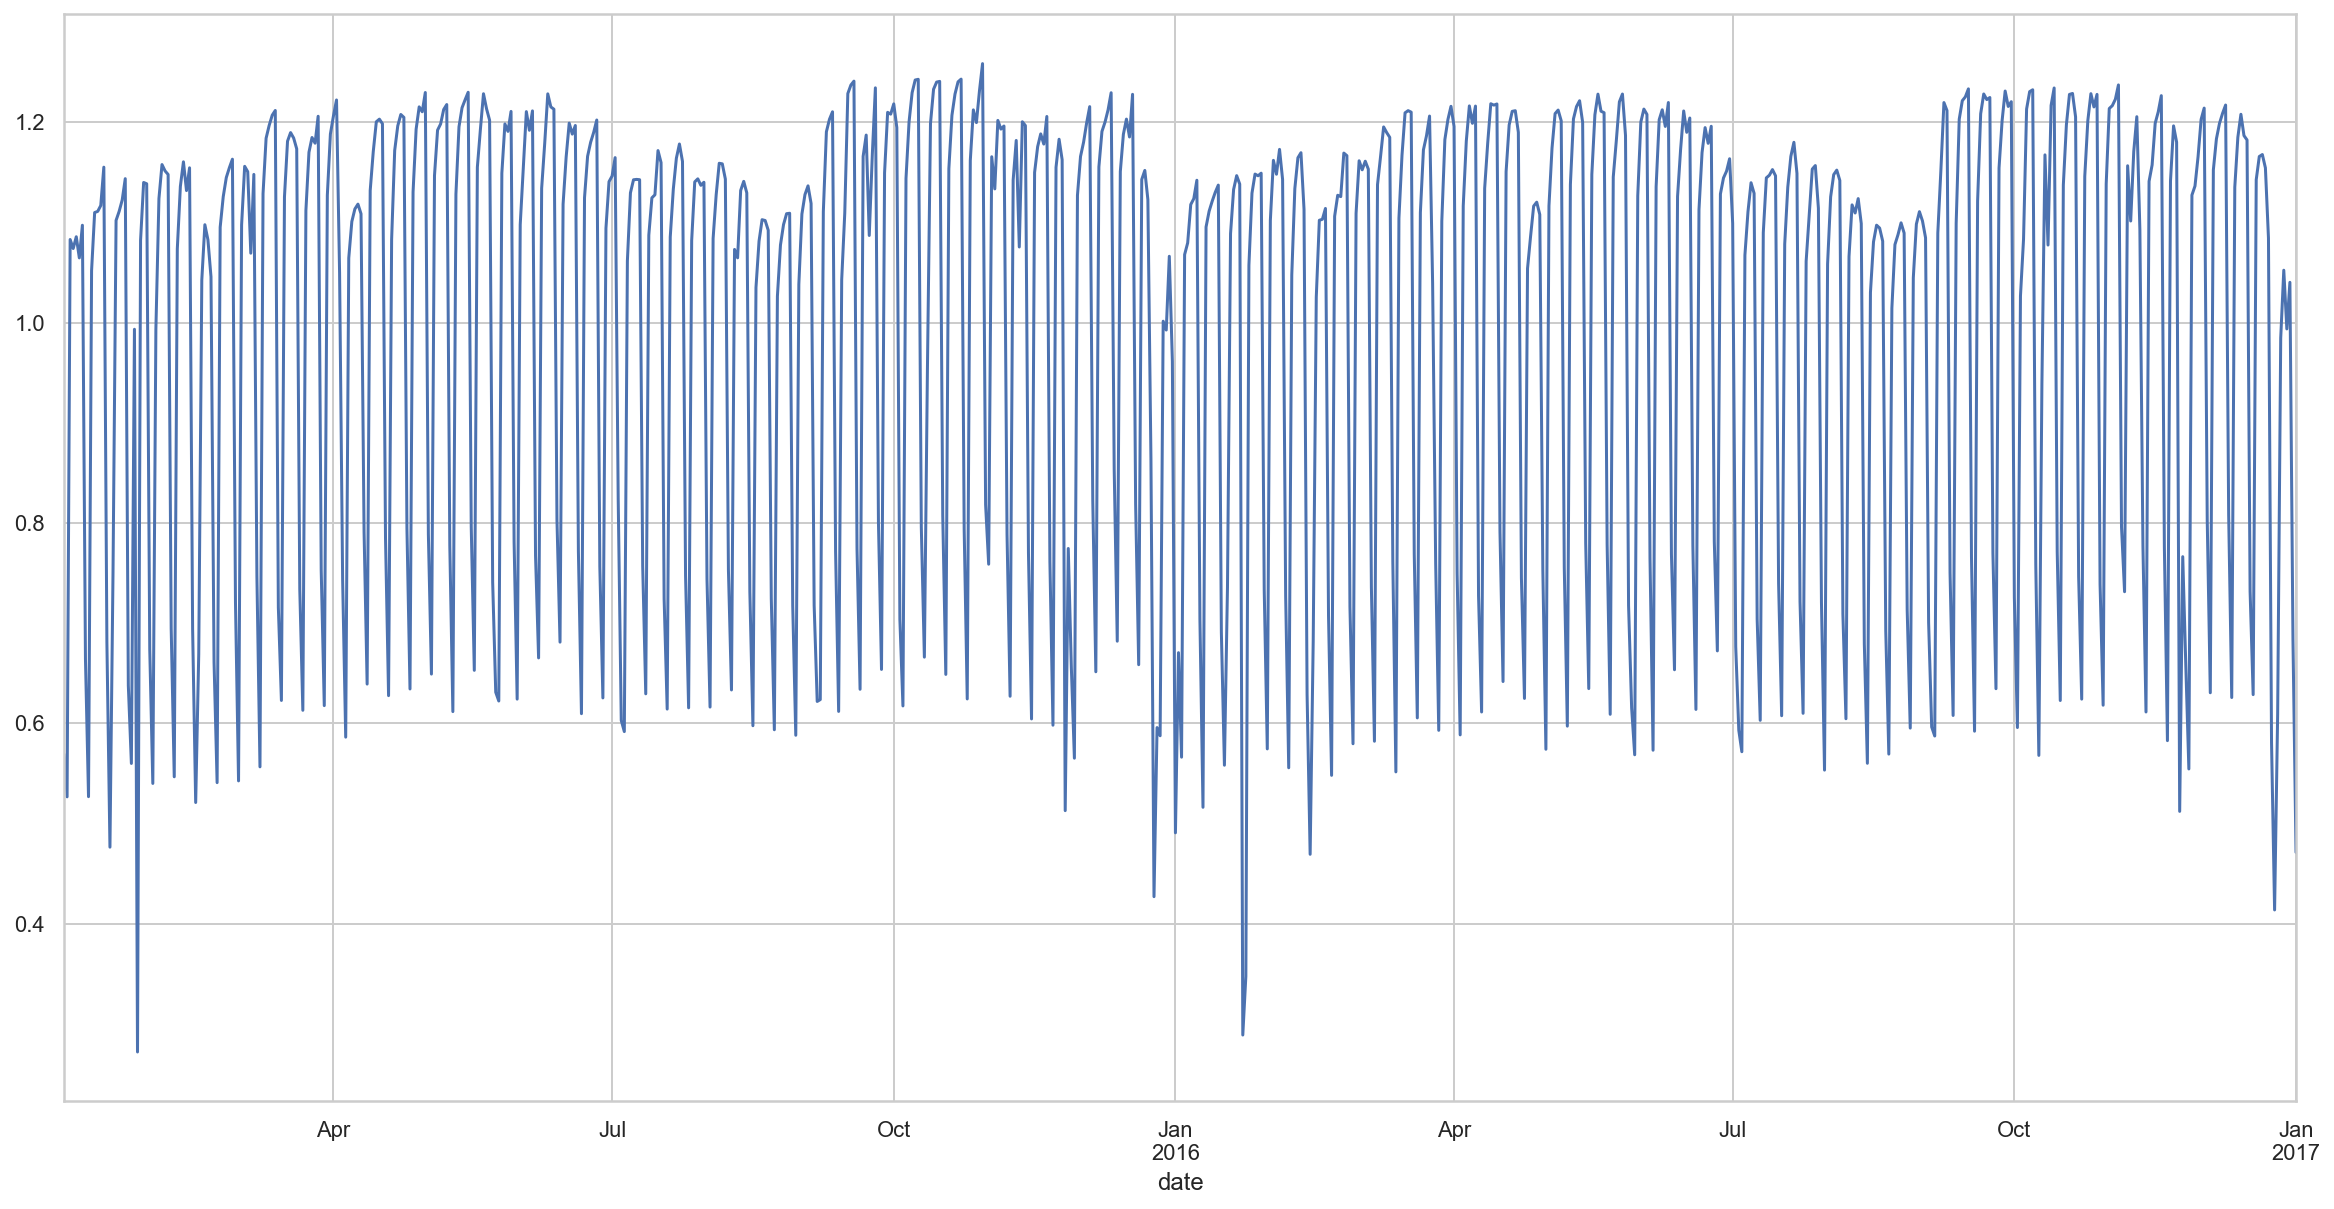

In [110]:
plt.figure(figsize=(20,10))
df_preCovid['entries_detrended'] = df_preCovid['entries_diff'] / df_preCovid['trend']
df_preCovid['entries_detrended'][:730].plot()
plt.show()

### Factor model

In [116]:
def remove_weekday_profile(row):
    return row['entries_detrended'] / weekday_factor[row['weekday']] 
def remove_month_profile(row):
    return row['entries_detrended_deweekdayed'] / month_factor[row['month']]

pred = f(trend) * f(weekday) * f(month)

In [114]:
weekday_factor = df_preCovid.groupby('weekday')['entries_detrended'].mean().to_dict()
weekday_factor

{0: 1.0588606161352792,
 1: 1.1438514944420606,
 2: 1.1713828784114961,
 3: 1.1668333274657314,
 4: 1.162766715564485,
 5: 0.7225059094270215,
 6: 0.5840887317633129}

In [117]:
df_preCovid['entries_detrended_deweekdayed']  = df_preCovid.apply(remove_weekday_profile, axis=1                                                              )

In [115]:
month_factor = df_preCovid.groupby('month')['entries_detrended'].mean().to_dict()
month_factor

{1: 0.9291125378889891,
 2: 0.9680345557804182,
 3: 1.0176400996312998,
 4: 1.0315201276896933,
 5: 1.038388628751256,
 6: 1.0462923048271433,
 7: 0.9737059977107659,
 8: 0.9766733631167505,
 9: 1.0184195927744897,
 10: 1.0543622944661082,
 11: 1.0051709396273005,
 12: 0.9763741441348673}

In [118]:
df_preCovid['entries_detrended_deweekdayed_demonthed']  = df_preCovid.apply(remove_month_profile, axis=1)

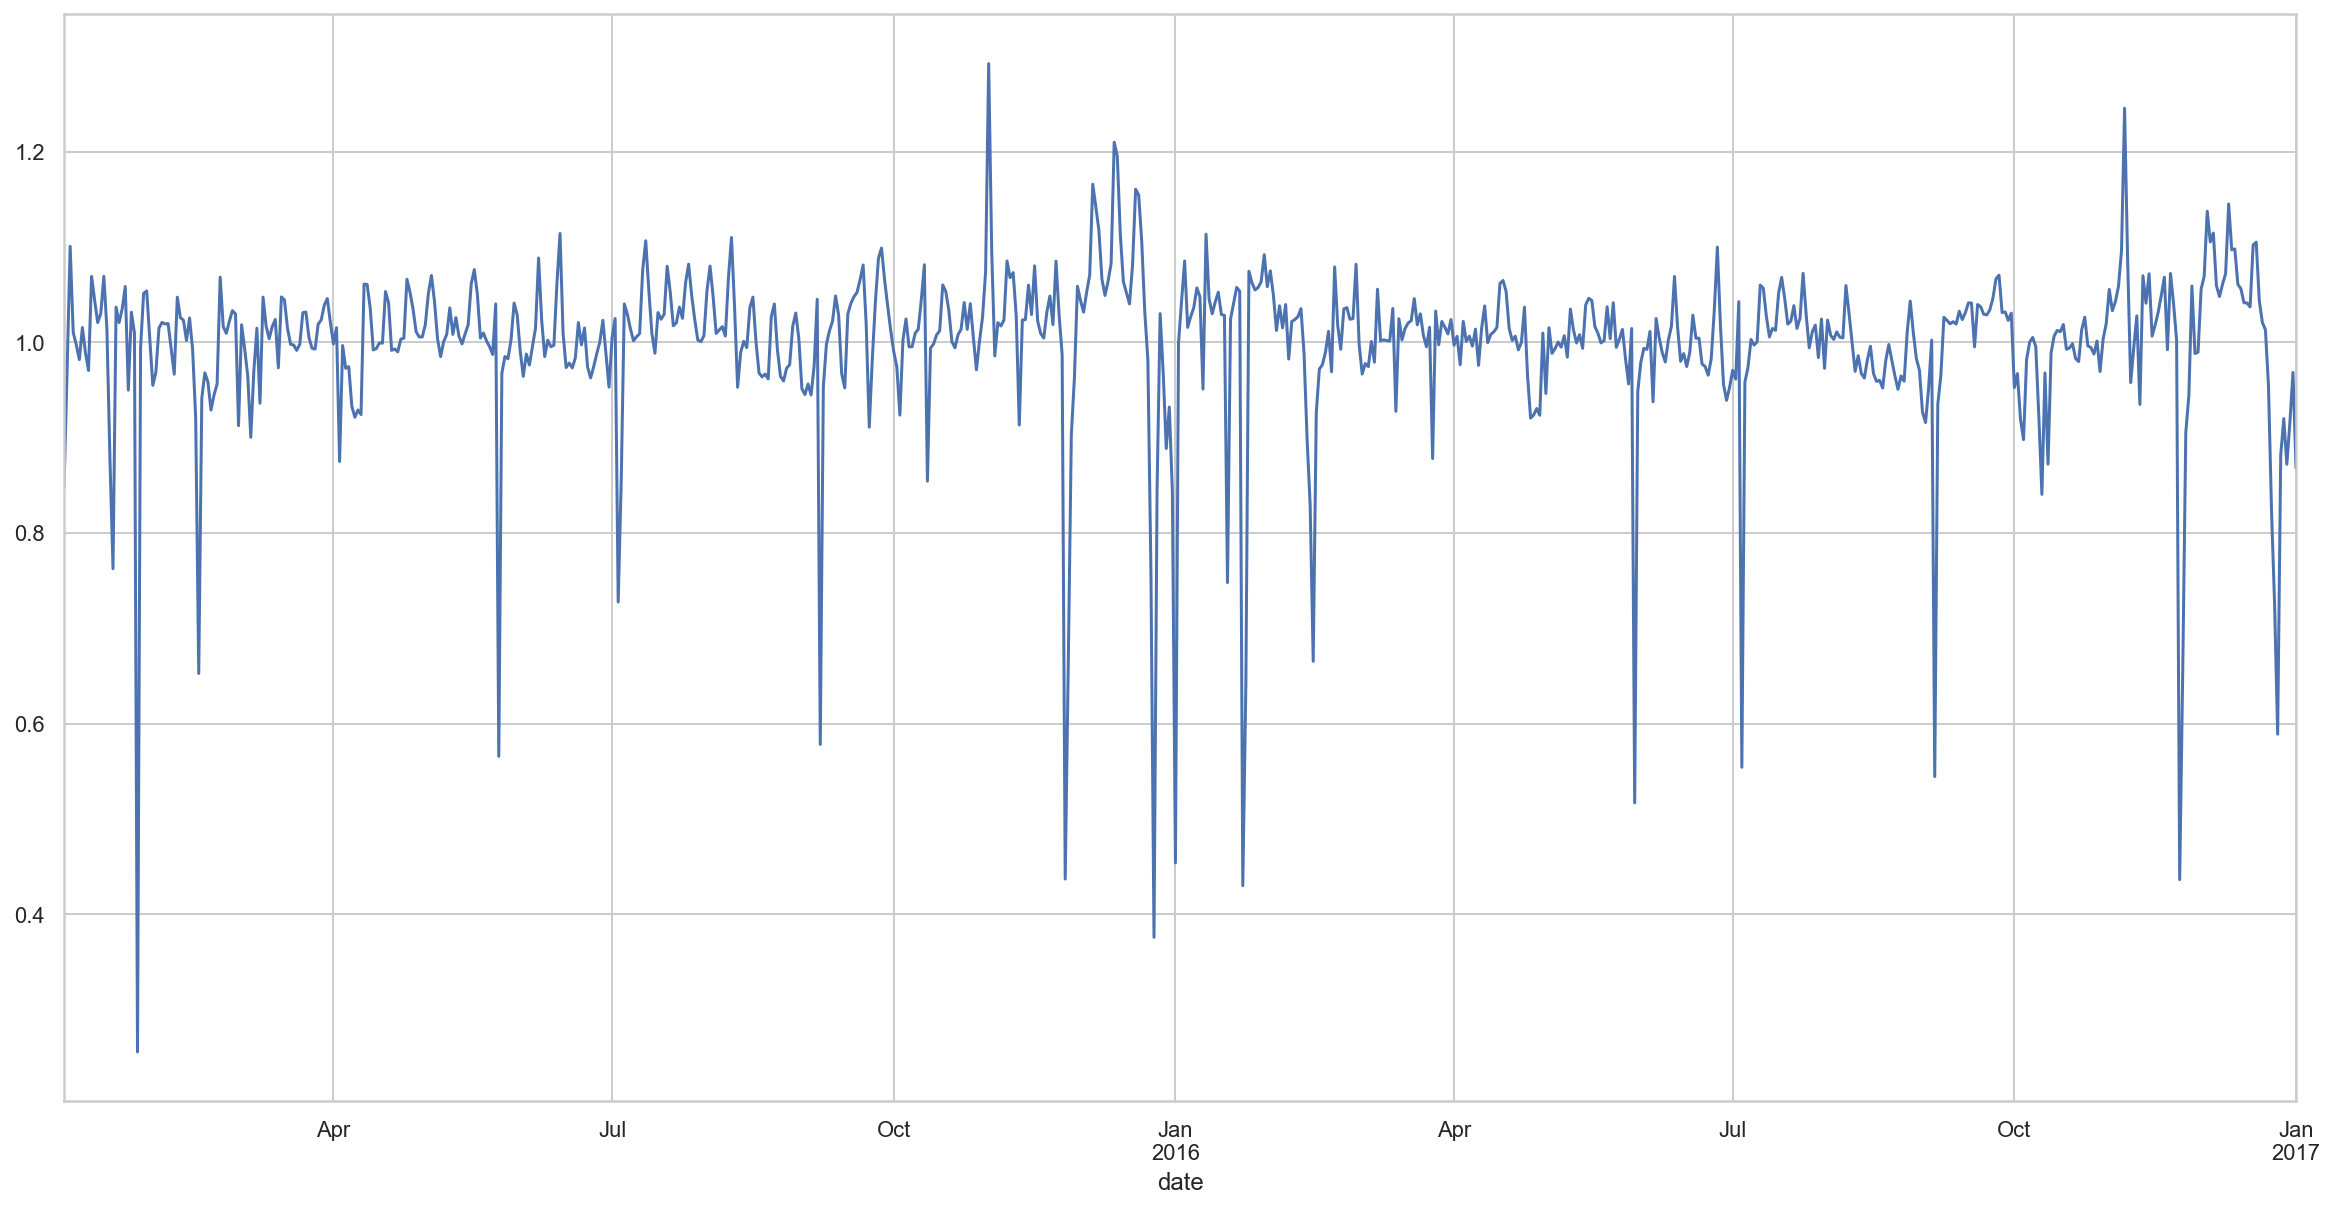

In [120]:
plt.figure(figsize=(20,10))
df_preCovid['entries_detrended_deweekdayed_demonthed'][:730].plot()
plt.show()

In [127]:
df_preCovid_train = df_preCovid[df_preCovid.index<'2019-01-01'] #(2015-01-03~2018-12-31)
df_preCovid_test = df_preCovid[~(df_preCovid.index<'2019-01-01')] #(2019-01-01~2020-02-29)

In [121]:
def factor_model(row):
    return row['trend'] * weekday_factor[row['weekday']] * month_factor[row['month']]

In [128]:
df_preCovid_train['factor_model'] = df_preCovid_train.apply(factor_model, axis=1)
df_preCovid_test['factor_model'] = df_preCovid_test.apply(factor_model, axis=1)

In [130]:
df_preCovid_train.head()

,entries_diff,exit_diff,timediff,year,month,day,weekday,timeindex,trend,entries_detrended,entries_detrended_deweekdayed,entries_detrended_deweekdayed_demonthed,factor_model
date,,,,,,,,,,,,,
2015-01-03,2682846.0,2175723.0,NaN,2015,1,3,5,0.0,4.713360e+06,0.569200,0.787814,0.847921,3.164028e+06
2015-01-04,2481666.0,2028416.0,1.0,2015,1,4,6,1.0,4.713276e+06,0.526527,0.901450,0.970227,2.557820e+06
2015-01-05,5104111.0,4207769.0,1.0,2015,1,5,0,2.0,4.713192e+06,1.082941,1.022742,1.100773,4.636842e+06
2015-01-06,5061648.0,4224954.0,1.0,2015,1,6,1,3.0,4.713108e+06,1.073951,0.938890,1.010524,5.008935e+06
2015-01-07,5116883.0,4251015.0,1.0,2015,1,7,2,4.0,4.713024e+06,1.085690,0.926845,0.997559,5.129403e+06


### Evaluate

In [141]:
def evaluate(pred, truth):
    mae = np.mean(np.abs(pred - truth))
    plt.figure(figsize=(20,10))
    plt.plot(pred, label='prediction')
    plt.plot(truth, label='truth')
    plt.title("MAE: {:.2f}".format(mae))
    plt.legend()
    plt.show()
    return mae

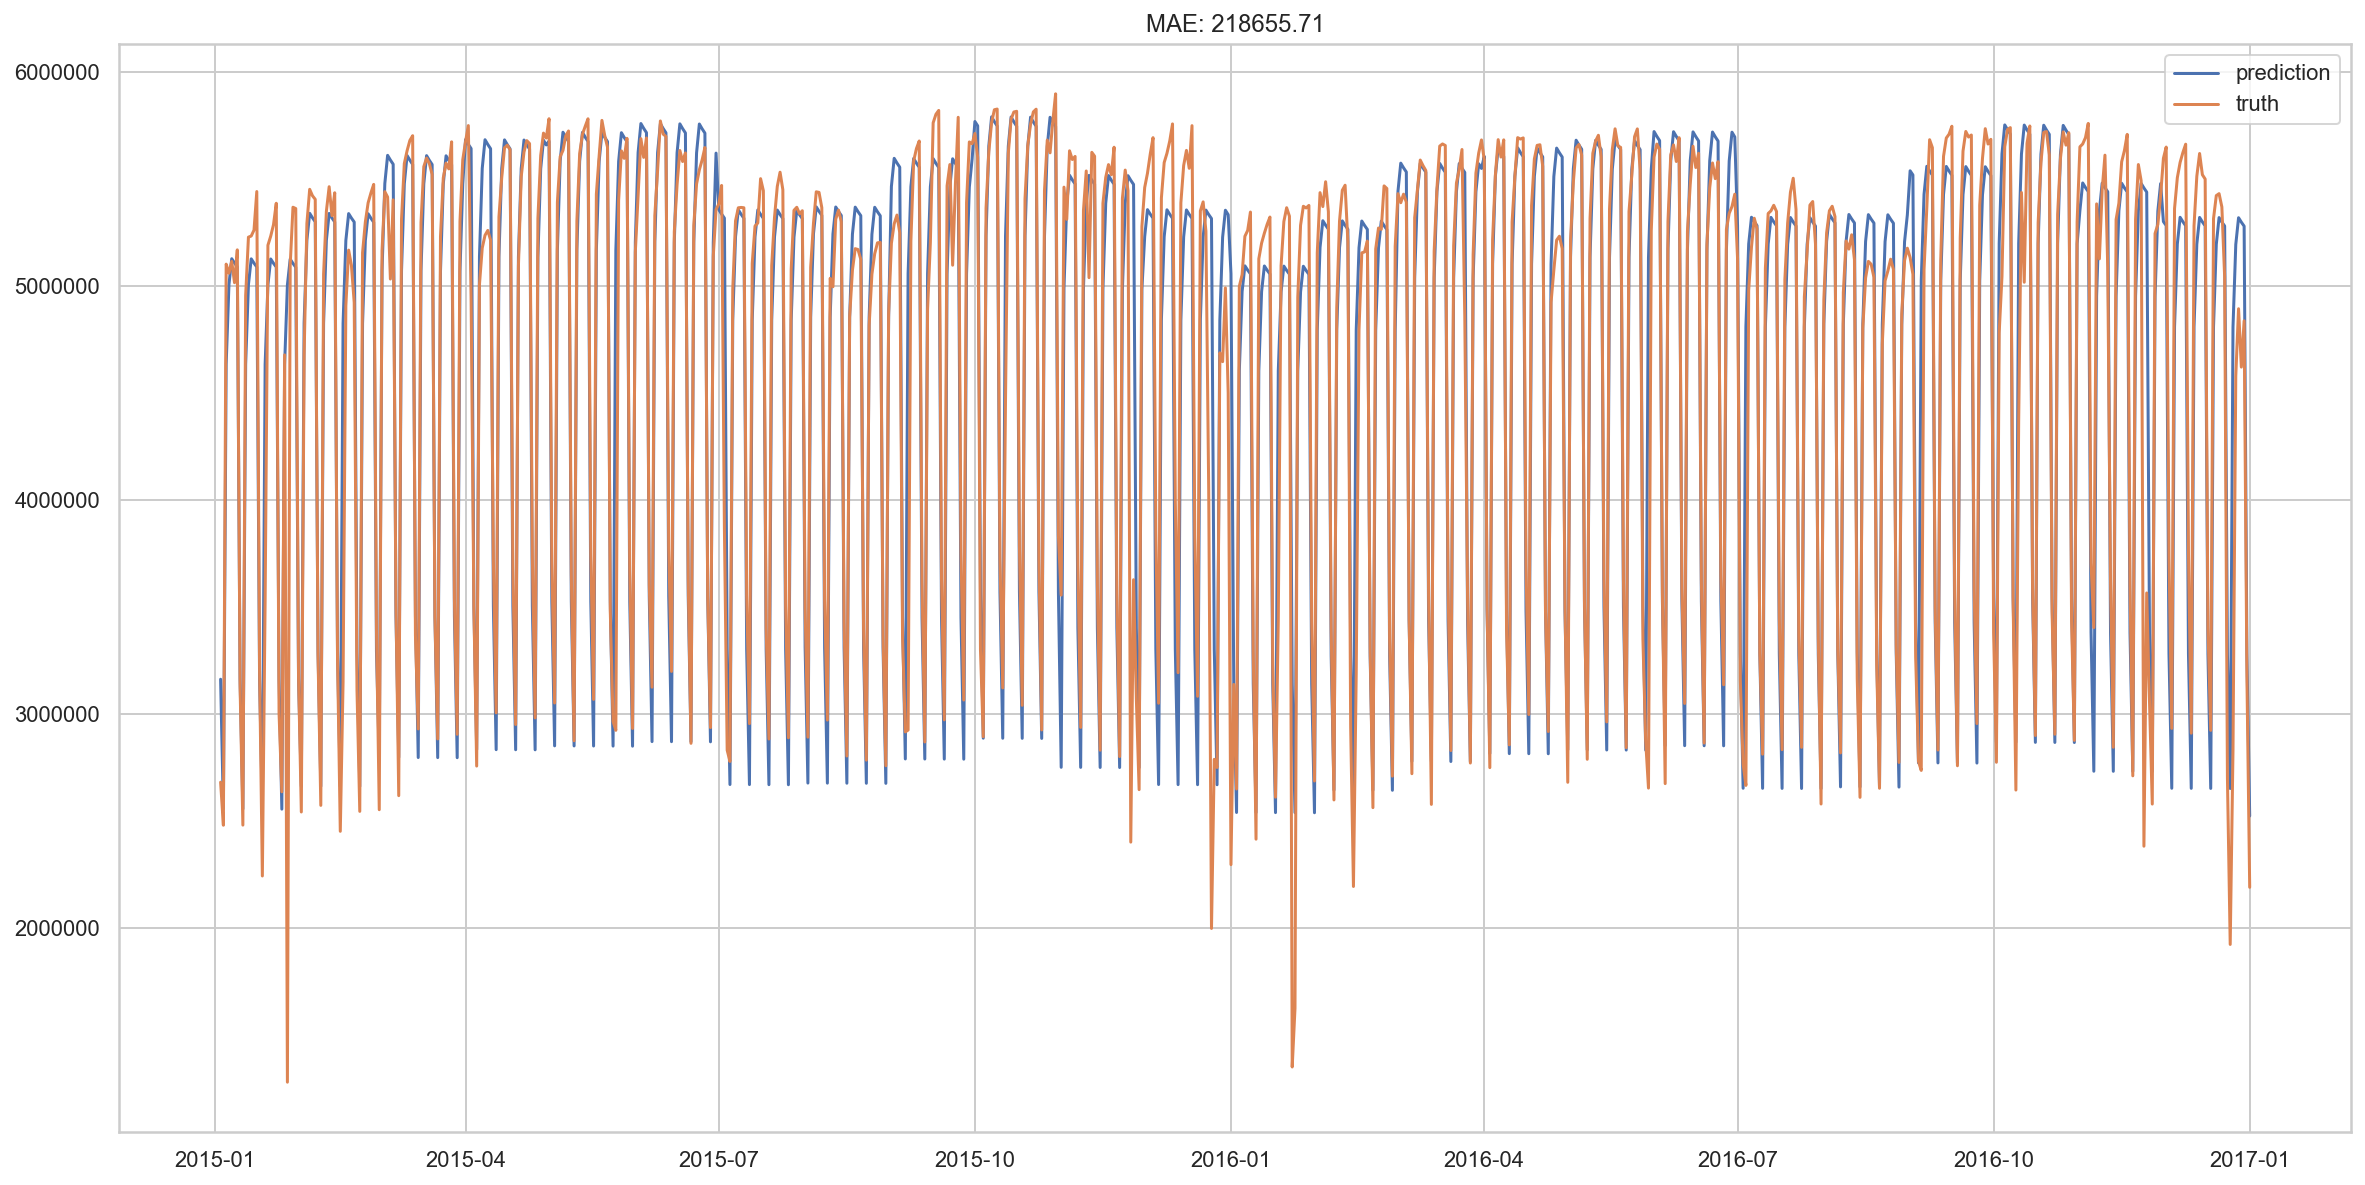

218655.71325801488

In [142]:
evaluate(df_preCovid_train['factor_model'][:730], df_preCovid_train['entries_diff'][:730])

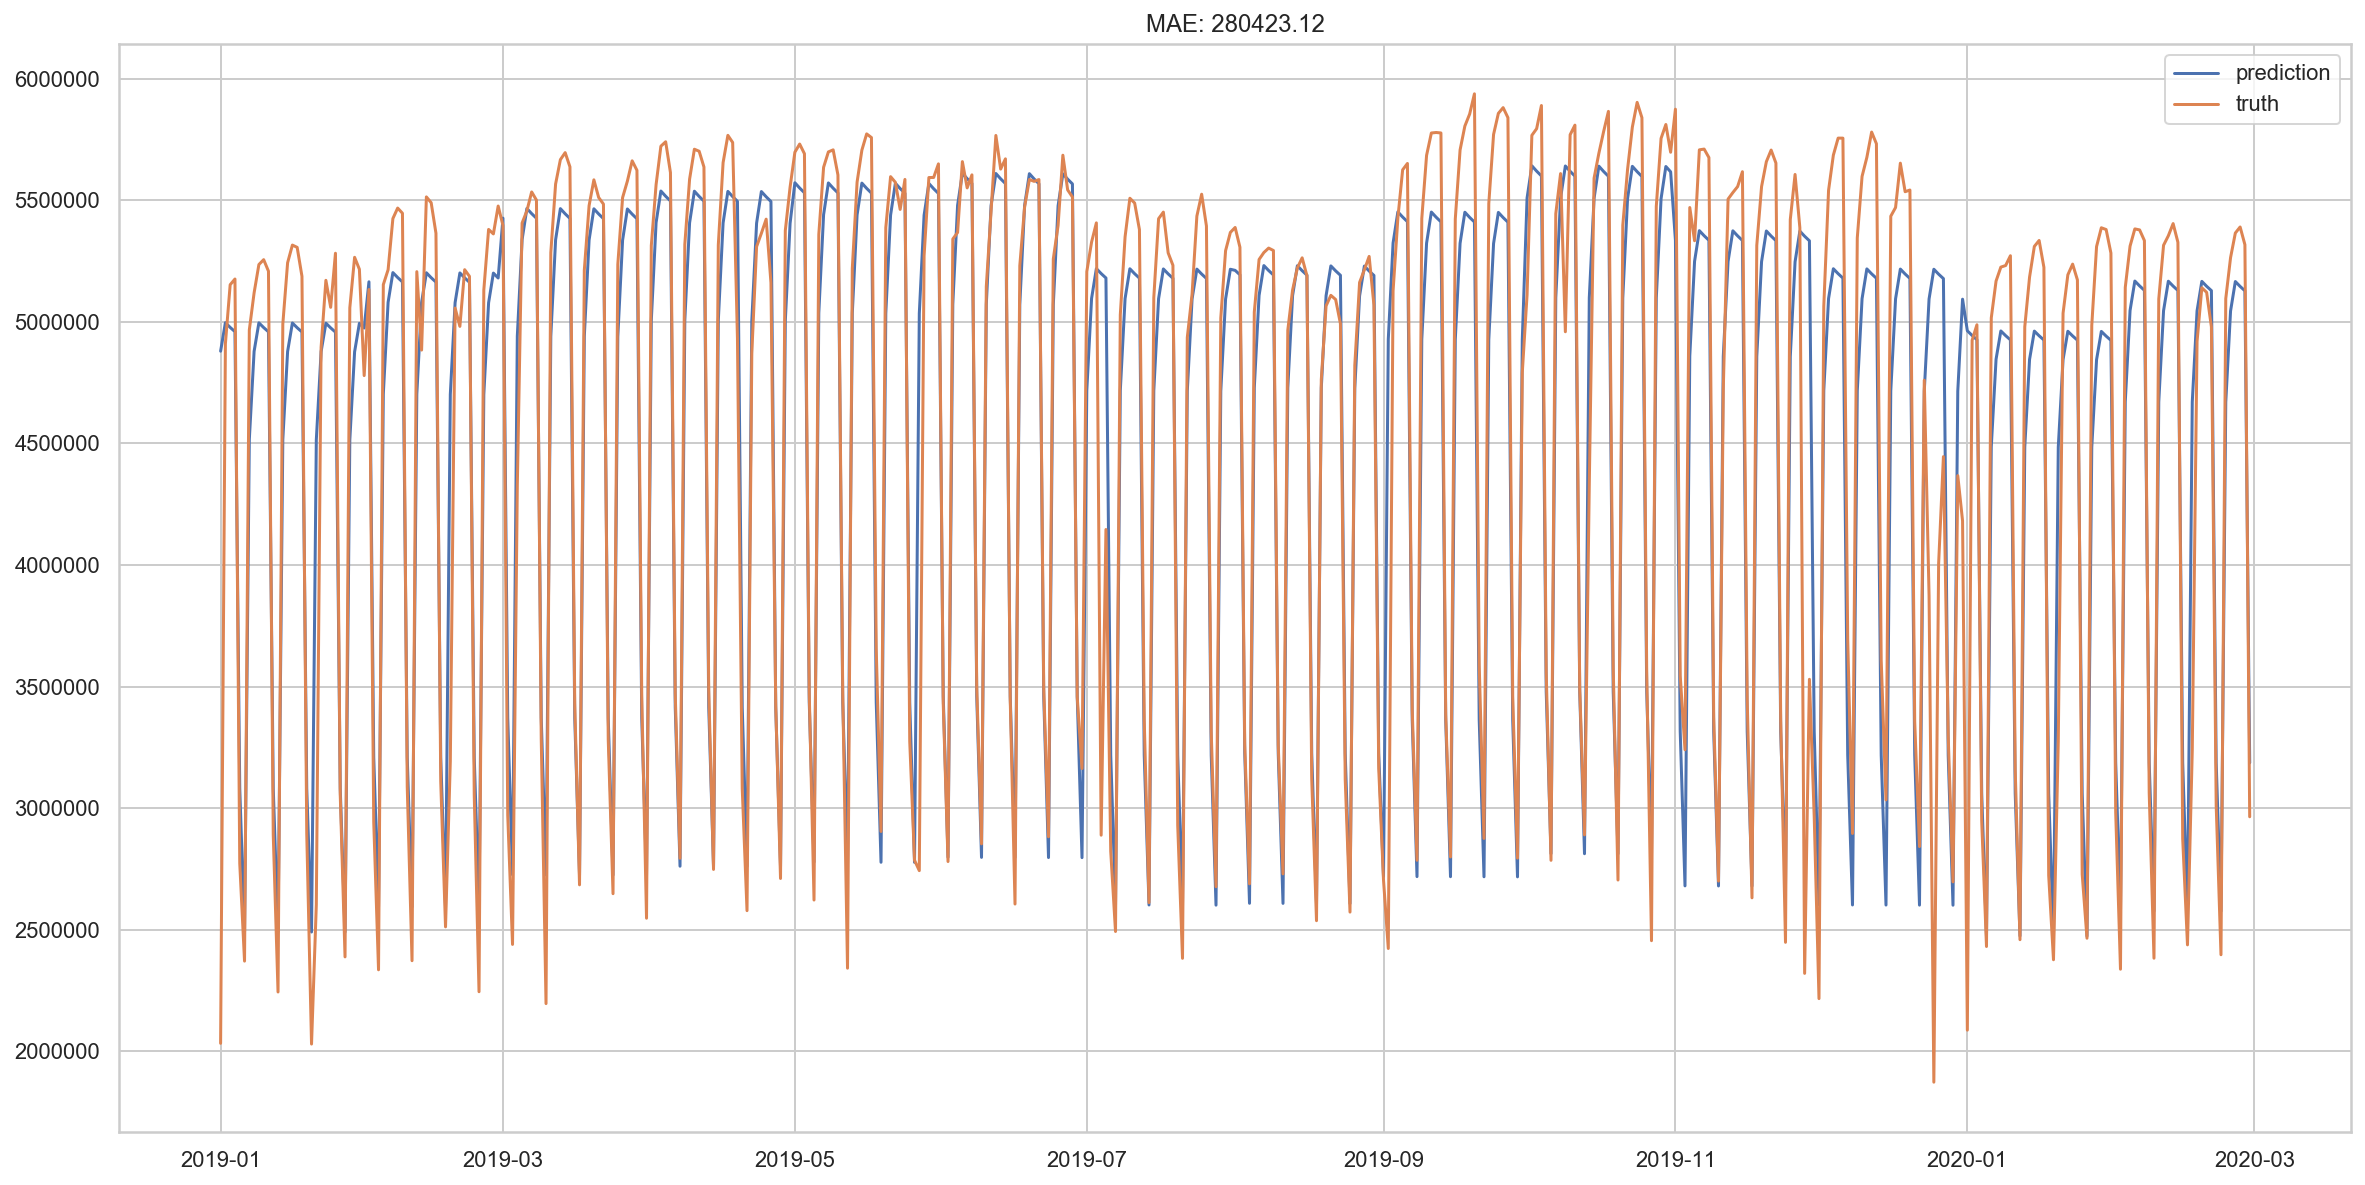

280423.1172091686

In [143]:
evaluate(df_preCovid_test['factor_model'][:730], df_preCovid_test['entries_diff'][:730])

## ARMA on residuals
- entries with detrended, deweekdayed, demonthed

In [144]:
residual_train = df_preCovid_train['entries_detrended_deweekdayed_demonthed']
residual_test = df_preCovid_test['entries_detrended_deweekdayed_demonthed']

### Plot acf and pacf

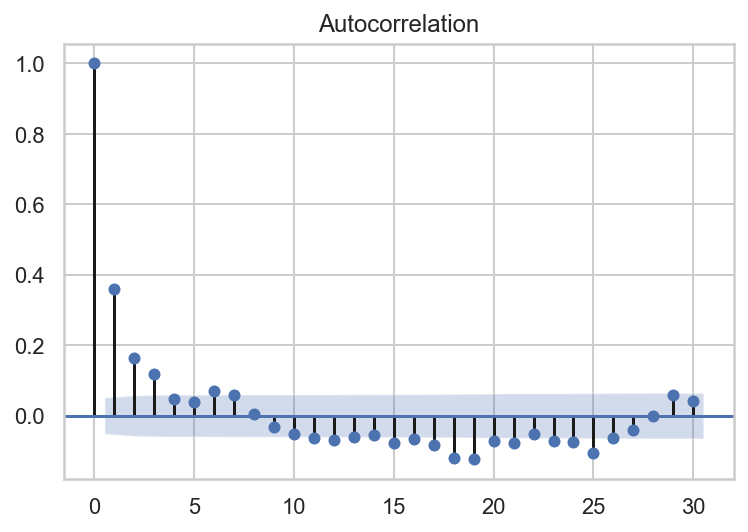

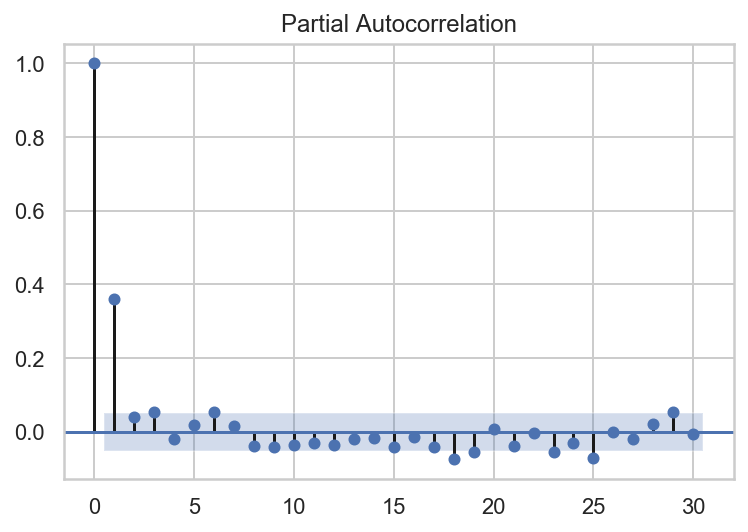

In [147]:
plot_acf(residual_train, lags=30)
plt.show()

plot_pacf(residual_train, lags=30)
plt.show()

### Find best AR and MA lags

In [150]:
best_ar_lags, best_ma_lags = minic([1], [1, 2, 3], residual_train, crit='AIC')
print(best_ar_lags, best_ma_lags)

(1,) (1, 2, 3)


### Fit ARMA(1,0) Model

In [151]:
ar_lags = (1,)
ma_lags = ()

ar_lag_arr = make_lag_arr(ar_lags)
ma_lag_arr = make_lag_arr(ma_lags)

print(ar_lag_arr)
print(ma_lag_arr)

arma = ARMA(A=ar_lag_arr,
            B=ma_lag_arr,
            rand_state=0)

arma.fix_constants()

arma.est_params(residual_train)

(array([1.  , 0.01]), array([2, 1, 1]))
(array([1.]), array([1, 1, 1]))


      fun: -1144.7985912469778
 hess_inv: array([[8.33593644e-06]])
      jac: array([0.00054932])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 210
      nit: 4
     njev: 66
   status: 2
  success: False
        x: array([-0.99410973])

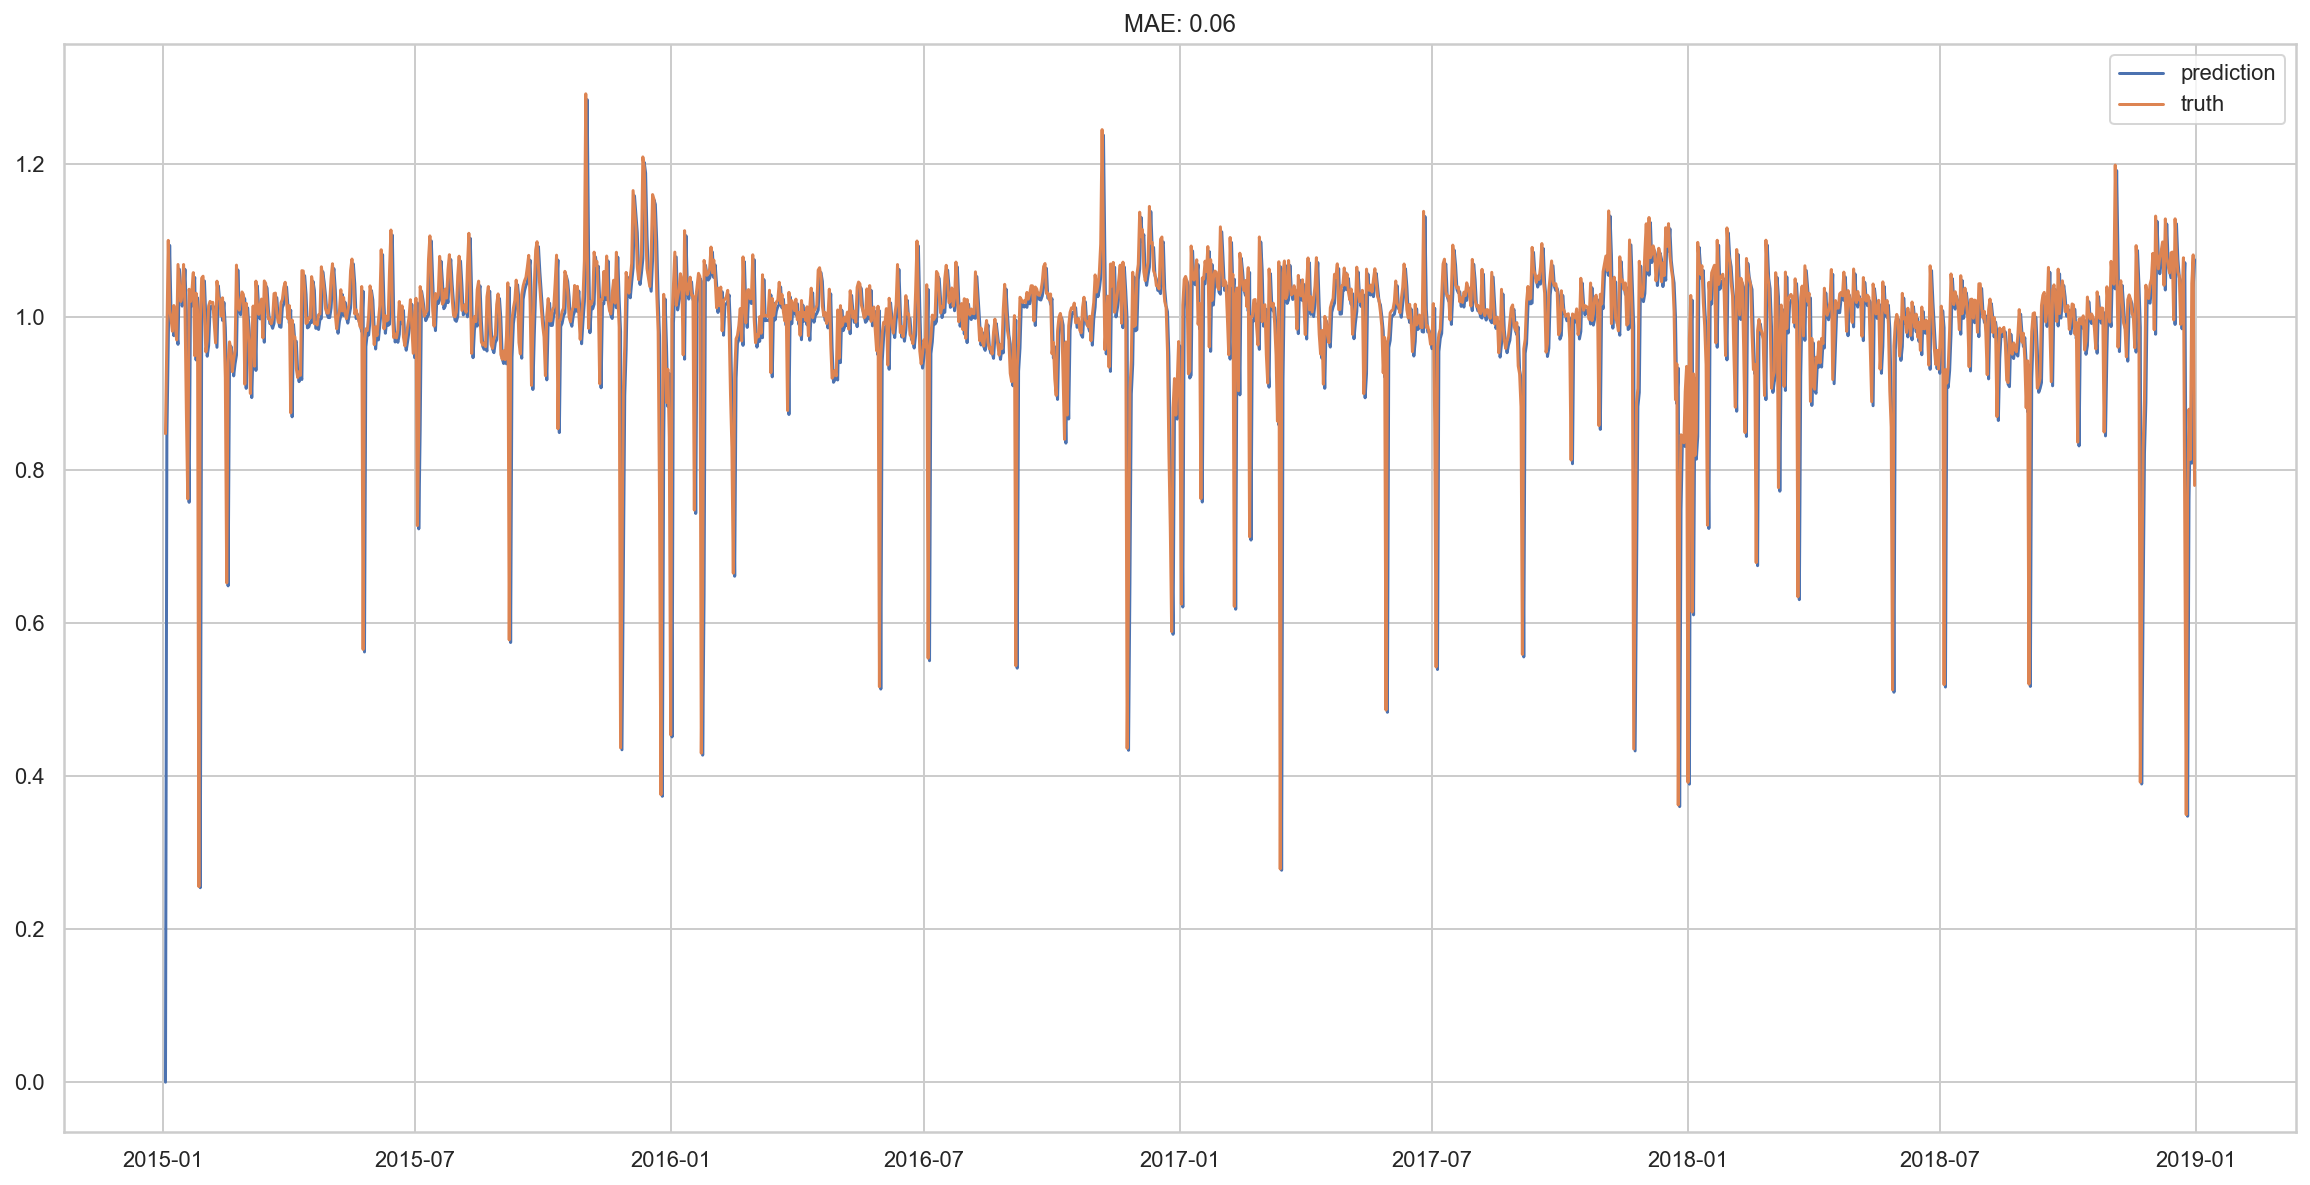

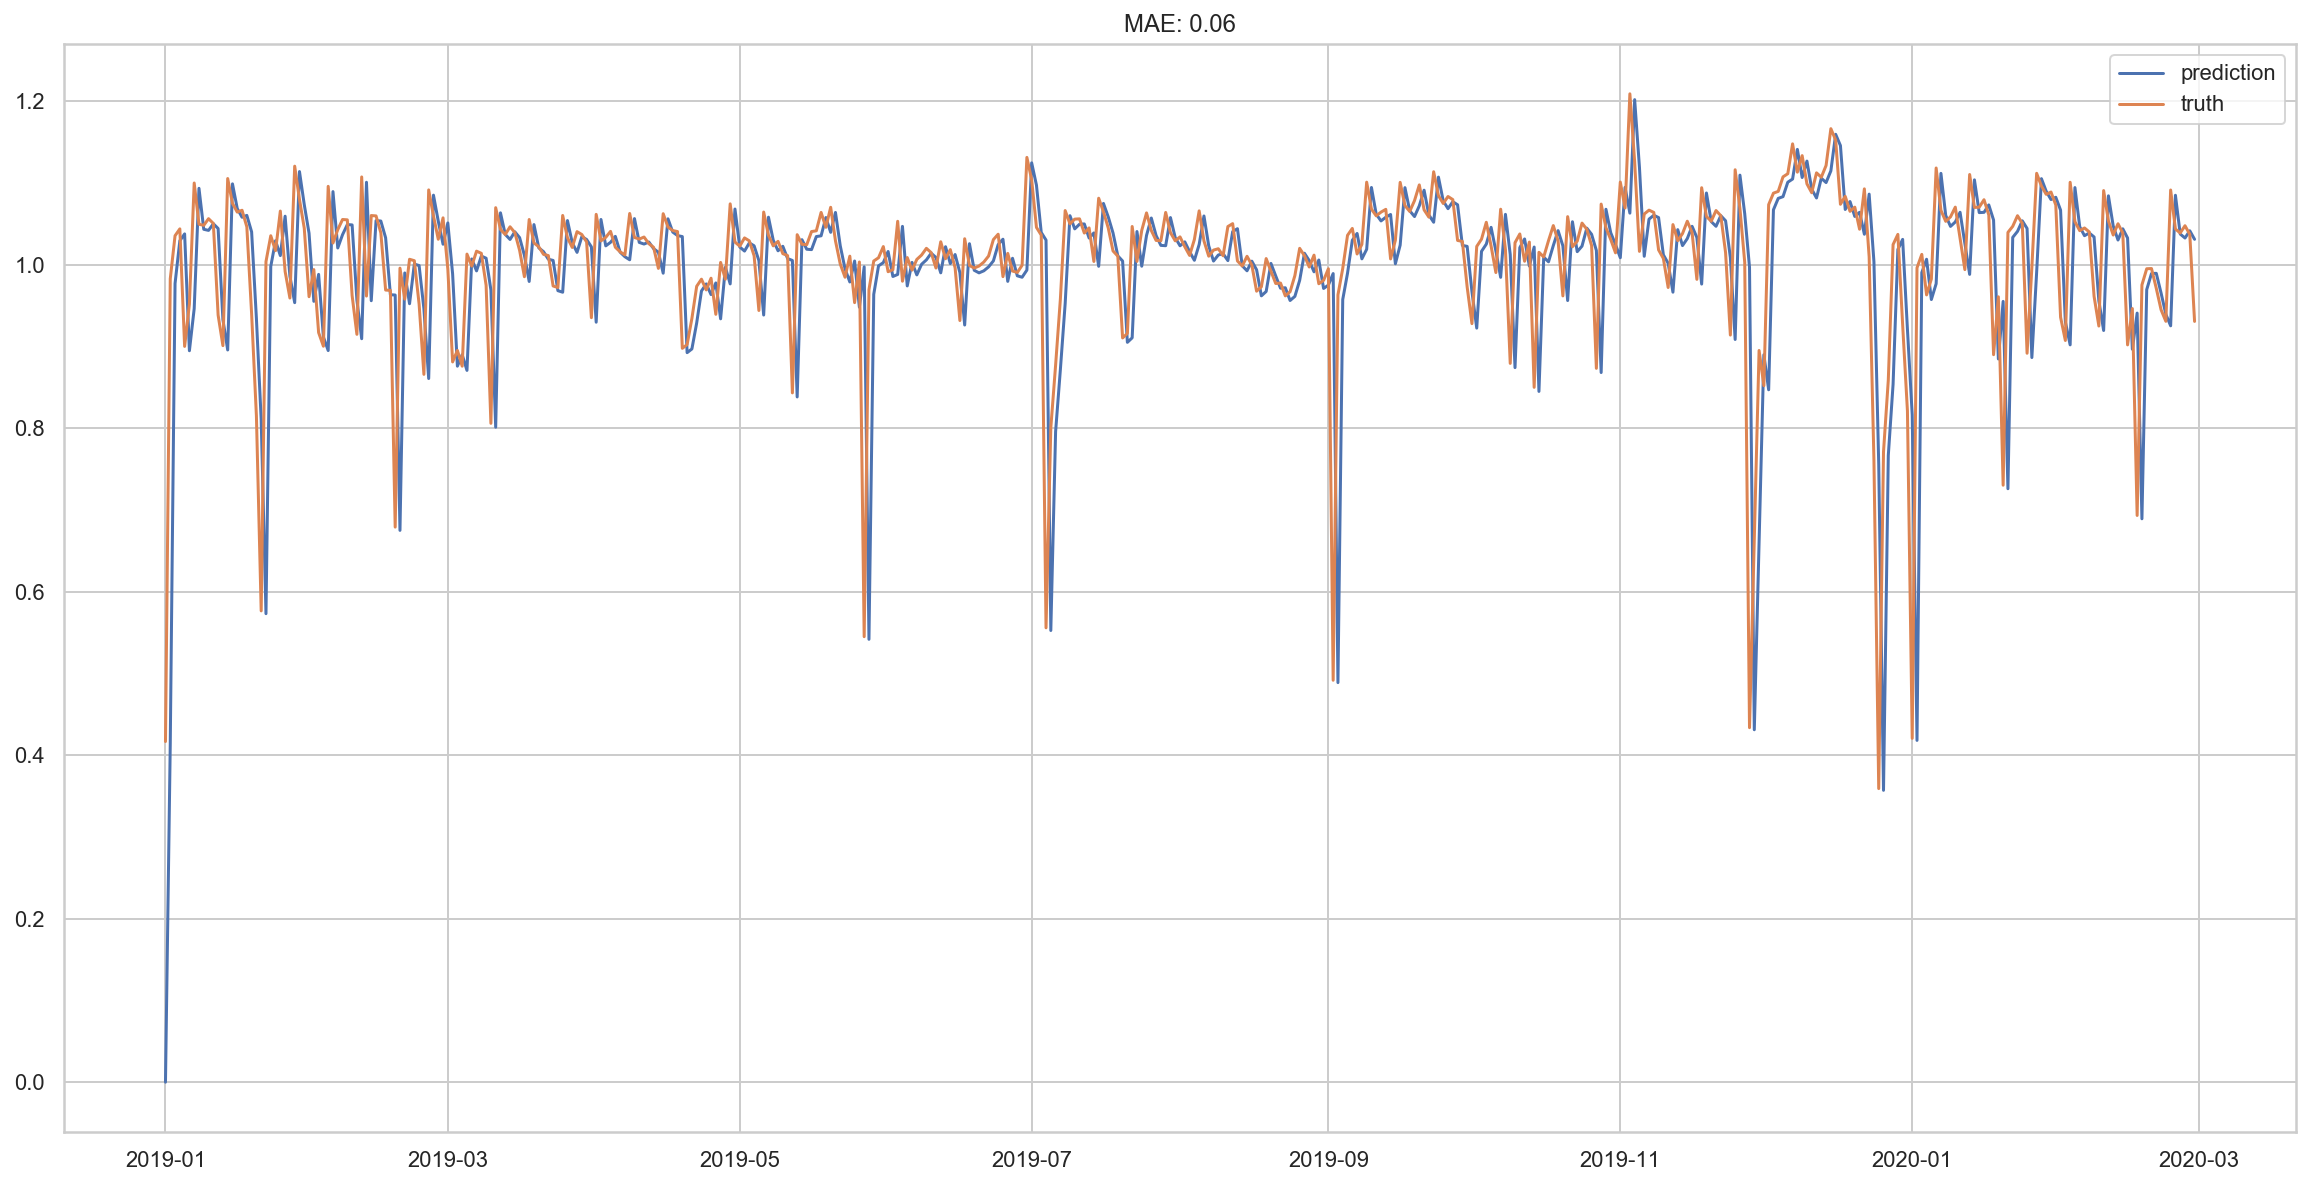

0.06038065745399835

In [152]:
df_preCovid_train['pred_arma_residual'] = arma.forecast(residual_train)[:, 0]
df_preCovid_test['pred_arma_residual'] = arma.forecast(residual_test)[:, 0]
evaluate(df_preCovid_train['pred_arma_residual'], residual_train)
evaluate(df_preCovid_test['pred_arma_residual'], residual_test)

### Plot acf and pacf of new residual

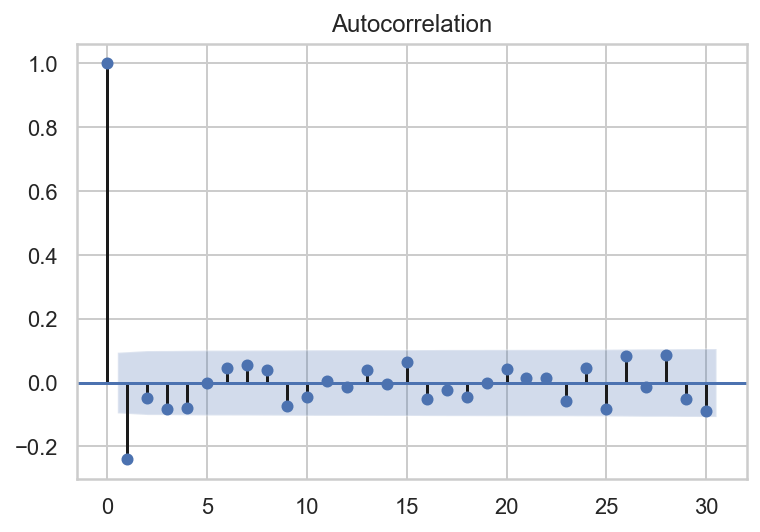

In [155]:
plot_acf(df_preCovid_test['pred_arma_residual'] - residual_test, lags=30)
plt.show()

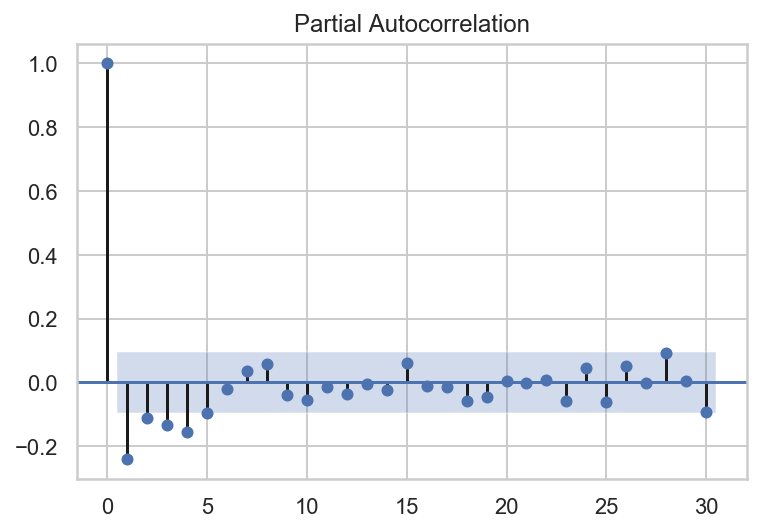

In [156]:
plot_pacf(df_preCovid_test['pred_arma_residual'] - residual_test, lags=30)
plt.show()

## SARIMAX

In [157]:
# Dataset
df_preCovid_train['lnEntries'] = np.log(df_preCovid_train['entries_diff'])

In [159]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(df_preCovid_train['lnEntries'] , order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/hyunjung/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                   D.DS12.lnEntries   No. Observations:                 1446
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -756.643
Date:                            Sun, 22 Nov 2020   AIC                           1521.285
Time:                                    21:29:50   BIC                           1542.392
Sample:                                01-16-2015   HQIC                          1529.163
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1397      0.039      3.618      0.000       0.064       0.215
ar.L2         -0.3361      0.027   